# **MSC 7208 Data Mining Semester Project**


The objective of this project is to use the mrjob library to write MapReduce jobs that analyze the Amazon Reviews dataset by implementing several MapReduce jobs to compute various metrics and insights from the data.

**Note: This notebook present the Analysis of tasks 1 to 6**

In [1]:
# Here are import the google colab library to work with google drive files

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# The code snipet in this cell is used to download the AWA dataset.

# To run the code, simply uncomment the code and execute the cell.

"""
import requests

# File URL
# file_url = "https://mcauleylab.ucsd.edu/public_datasets/data/amazon_2023/raw/review_categories/Industrial_and_Scientific.jsonl.gz"
file_url = "https://mcauleylab.ucsd.edu/public_datasets/data/amazon_2023/raw/meta_categories/meta_Industrial_and_Scientific.jsonl.gz"
# Destination path in Google Drive
dest_path = "/content/drive/MyDrive/MCSC1/Semester 2/Data Mining/dataset/meta_Industrial_and_Scientific.jsonl.gz"

# Download the file using requests
response = requests.get(file_url, stream=True)
response.raise_for_status()  # Raise an exception for bad responses

# Save the file to the destination path
with open(dest_path, "wb") as file:
    for chunk in response.iter_content(chunk_size=8192):
        if chunk:
            file.write(chunk)

print(f"File downloaded and saved to: {dest_path}")
"""

File downloaded and saved to: /content/drive/MyDrive/MCSC1/Semester 2/Data Mining/dataset/meta_Industrial_and_Scientific.jsonl.gz


# **Exploratory Data Analysis**

In [ ]:
# Here we import the prerequisit library to work with the project

import pandas as pd
import gzip
import json
import pandas as pd
import gzip
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# A python function to parse the dataset

def parse(path):
    # Check if file is gzipped before opening with gzip.open
    try:
        with gzip.open(path, 'rb') as g:
            for l in g:
                yield json.loads(l)
    except gzip.BadGzipFile:
        # If not gzipped, open as regular file
        with open(path, 'r') as f:
            for l in f:
                yield json.loads(l)

def getDF(path):
    df_list = [d for d in parse(path)]  # Collect all JSON objects in a list
    return pd.DataFrame(df_list)  # Convert list of dicts into a DataFrame

# Path to your file in Google Drive
file_path = "/content/drive/MyDrive/MCSC1/Semester 2/DataMining/SemesterProject/dataset/Industrial_and_Scientific.jsonl"

In [ ]:
# Display the first few rows to verify
df = getDF(file_path)

In [ ]:
# Display column names
print("Column Names:", df.columns.tolist())

Column Names: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']


In [ ]:
# Check dataset shape
print(f"Dataset contains {df.shape[0]} rows and {df.shape[1]} columns.")

Dataset contains 5183005 rows and 10 columns.


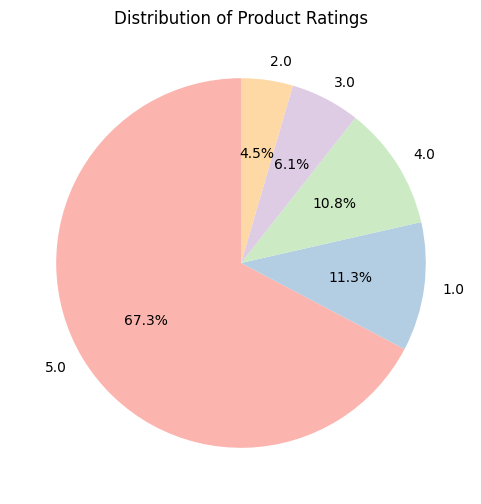

In [ ]:
# A python function to visualize the distribution of user rating

import matplotlib.pyplot as plt

# Check if the 'rating' column exists before plotting
if 'rating' in df.columns:
    # Get the counts of each rating
    rating_counts = df['rating'].value_counts()

    # Create the pie chart
    plt.figure(figsize=(6, 6))  # Adjust figure size as needed
    rating_counts.plot(
        kind='pie',
        autopct='%1.1f%%',
        startangle=90,
        colors=plt.cm.Pastel1.colors[:len(rating_counts)]
    )
    plt.title('Distribution of Product Ratings')
    plt.ylabel('')  # Remove y-axis label
    plt.show()
else:
    print("'rating' column not found. Cannot create pie chart.")


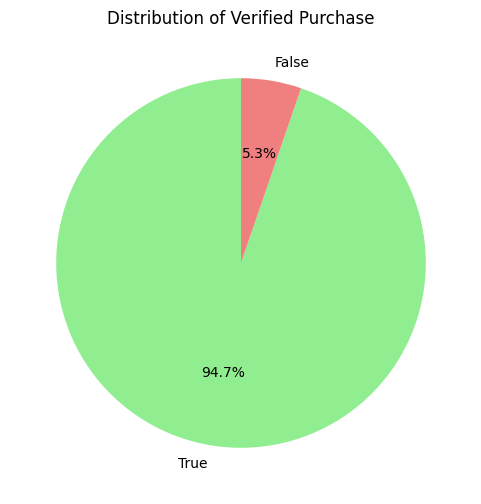

In [ ]:
# A python function to visualize verified purchases

import matplotlib.pyplot as plt

# Check if the 'verified' column exists before plotting
if 'verified_purchase' in df.columns:
    # Get the counts of verified vs. unverified purchases
    verified_purchase = df['verified_purchase'].value_counts()

    # Create the pie chart
    plt.figure(figsize=(6, 6)) # Adjust figure size as needed
    verified_purchase.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['lightgreen', 'lightcoral'])
    plt.title('Distribution of Verified Purchase')
    plt.ylabel('') # Remove the default 'verified' label on the y-axis
    plt.show()
else:
    print("'verified' column not found. Cannot create pie chart for verified purchases.")

**Get number of unique products**

In [ ]:
%%writefile /content/unique_product_count.py
import json
from mrjob.job import MRJob
from mrjob.step import MRStep

class UniqueProductCount(MRJob):

    def steps(self):
        return [
            MRStep(mapper=self.mapper_get_asins,
                   reducer=self.reducer_unique_asins),
            MRStep(mapper=self.mapper_prepare_for_count,
                   reducer=self.reducer_count_unique)
        ]

    def mapper_get_asins(self, _, line):
        try:
            review = json.loads(line)
            asin = review.get('asin')
            if asin:
                yield asin, None
        except json.JSONDecodeError:
            pass  # Skip invalid JSON lines

    def reducer_unique_asins(self, asin, _):
        yield "unique", 1  # Emit a count for each unique ASIN

    def mapper_prepare_for_count(self, key, value):
        yield "total_unique_count", value

    def reducer_count_unique(self, key, values):
        yield "Total Unique Products", sum(values)

if __name__ == '__main__':
    UniqueProductCount.run()


Writing /content/unique_product_count.py


In [ ]:
!python /content/unique_product_count.py "/content/drive/MyDrive/MCSC1/Semester 2/DataMining/SemesterProject/dataset/Industrial_and_Scientific.jsonl" > /content/unique_products.txt

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/unique_product_count.root.20250521.160617.243232
Running step 1 of 2...
Running step 2 of 2...
job output is in /tmp/unique_product_count.root.20250521.160617.243232/output
Streaming final output from /tmp/unique_product_count.root.20250521.160617.243232/output...
Removing temp directory /tmp/unique_product_count.root.20250521.160617.243232...


# 1. Setup and Preparation

(a) Install and configure the mrjob library on your development environment.

In [5]:
!pip install  mrjob

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.6/439.6 kB 5.9 MB/s eta 0:00:00


In [6]:
# check if it has been installed and it working.

import mrjob
print(mrjob.__version__)

0.7.4


(b) Download and examine the Amazon Reviews dataset to understand its structure.

In [ ]:
import json

dataset_path = "/content/drive/MyDrive/MCSC1/Semester 2/DataMining/SemesterProject/dataset/Industrial_and_Scientific.jsonl"

Extract the column names (keys) from the dataset.

In [ ]:

with open(dataset_path, 'r') as f:
    for i, line in enumerate(f):
        if i == 0:  # Print the column names (keys) from the first line
            review = json.loads(line.strip())
            column_names = list(review.keys())  # Extract keys from the first JSON object
            print("Column Names:", column_names)
            break  # No need to continue after the first line

Column Names: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']


Reads the first five lines from a .jsonl file located at the given path, and prints the content of each line as a Python dictionary

In [ ]:
with open(dataset_path, 'r') as f:
    for i, line in enumerate(f):
        if i < 5:  # Print first 5 lines
            review = json.loads(line.strip())
            print(review)
        else:
            break

{'rating': 5.0, 'title': 'Best value for the money', 'text': "These masks are great even though there is no 'inside' or 'outside' to let you know whether the mask is inside out or not. They do the job and I've ordered these a couple of times now without hesitation.", 'images': [], 'asin': 'B08C7HDF1F', 'parent_asin': 'B0BX2672L8', 'user_id': 'AG2L7H23R5LLKDKLBEF2Q3L2MVDA', 'timestamp': 1676602453163, 'helpful_vote': 3, 'verified_purchase': True}
{'rating': 5.0, 'title': 'TOO good.', 'text': 'These scissors are so good they got stolen by one of the home care aides. Really super sharp and sturdy scissors which I have no choice but to have to order again.', 'images': [], 'asin': 'B07BT4YLHT', 'parent_asin': 'B07BT4YLHT', 'user_id': 'AG2L7H23R5LLKDKLBEF2Q3L2MVDA', 'timestamp': 1671844170434, 'helpful_vote': 1, 'verified_purchase': True}
{'rating': 4.0, 'title': 'Good', 'text': 'Good. Sensor push easier to work with but these are more reliable', 'images': [], 'asin': 'B06XY65HCX', 'parent_a

# 2. Count the Number of Reviews per Product

**(a) Write a MapReduce job that maps each review to its product ID.**

Mapper

- Parses each line of the input as JSON and emits (asin, 1) — a count of one review per product.

Combiner (optional but useful)

- Sums the counts locally to reduce data shuffling across the network.

Reducer

- Aggregates the final count of reviews per product.


In [ ]:
%%writefile /content/review_count.py
import json
import re
import logging
from mrjob.job import MRJob
import matplotlib.pyplot as plt
import numpy as np

class ReviewCount(MRJob):

    def configure_args(self):
        super(ReviewCount, self).configure_args()
        self.add_passthru_arg('--top-n', type=int, default=10, help='Number of top products to output')

    def mapper(self, _, line):
        try:
            review = json.loads(line)
            asin = review.get('asin')
            if asin:
                yield asin, 1
            else:
                logging.warning(f"Missing ASIN in record: {line[:50]}...")
        except json.JSONDecodeError as e:
            logging.error(f"Malformed JSON: {line[:50]}... Error: {e}")

    def combiner(self, product_id, counts):
        yield product_id, sum(counts)

    def reducer_init(self):
        self.review_counts = []

    def reducer(self, product_id, counts):
        total = sum(counts)
        self.review_counts.append((product_id, total))

    def reducer_final(self):
        import heapq
        top_n = self.options.top_n
        heap = []
        for product_id, total in self.review_counts:
            if len(heap) < top_n:
                heapq.heappush(heap, (total, product_id))
            else:
                heapq.heappushpop(heap, (total, product_id))
        for total, product_id in sorted(heap, reverse=True):
            yield None, json.dumps({"product_id": product_id, "total_reviews": total})

logging.basicConfig(level=logging.WARNING)

def visualize_reviews(json_file, output_image):
    products = []
    counts = []

    with open(json_file, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) != 2:
                logging.warning(f"Skipping malformed line: {line[:50]}...")
                continue

            try:
                # First parse outer string: gives you a JSON string
                json_str = json.loads(parts[1])

                # Now parse the JSON string into a dictionary
                data = json.loads(json_str)

                # Check if data is a dictionary
                if not isinstance(data, dict):
                    logging.warning(f"Skipping line where JSON did not parse to a dict: {line[:50]}...")
                    continue

                # Ensure expected keys are present
                if 'product_id' in data and 'total_reviews' in data:
                    products.append(data['product_id'])
                    counts.append(data['total_reviews'])
                else:
                    logging.warning(f"Missing keys in parsed data: {data}")
            except Exception as e:
                logging.warning(f"Error parsing line: {line[:50]}... Error: {e}")

    if not products:
        logging.error("No data to visualize after processing file.")
        return

    # Sort by number of reviews (descending)
    sorted_data = sorted(zip(products, counts), key=lambda x: x[1], reverse=True)

    # Use top 20 for visualization
    top_products, top_counts = zip(*sorted_data[:20])

    plt.figure(figsize=(12, 6))
    plt.bar(top_products, top_counts, color='skyblue')
    plt.xticks(rotation=90)
    plt.title('Top 20 Products by Total Reviews')
    plt.xlabel('Product ID')
    plt.ylabel('Total Reviews')
    plt.tight_layout()
    plt.savefig(output_image)
    plt.close()
    print(f"Chart saved to {output_image}")
if __name__ == '__main__':
    logging.basicConfig(level=logging.INFO)
    ReviewCount.run()


Overwriting /content/review_count.py


In [ ]:
!python /content/review_count.py --top-n 50 "/content/drive/MyDrive/MCSC1/Semester 2/DataMining/SemesterProject/dataset/Industrial_and_Scientific.jsonl" > /content/output.json

No configs found; falling back on auto-configuration
INFO:mrjob.conf:No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/review_count.root.20250521.162917.192014
INFO:mrjob.runner:Creating temp directory /tmp/review_count.root.20250521.162917.192014
Running step 1 of 1...
INFO:mrjob.sim:Running step 1 of 1...
job output is in /tmp/review_count.root.20250521.162917.192014/output
INFO:mrjob.runner:job output is in /tmp/review_count.root.20250521.162917.192014/output
Streaming final output from /tmp/review_count.root.20250521.162917.192014/output...
INFO:mrjob.runner:Streaming final output from /tmp/review_count.root.20250521.162917.192014/output...
Removing temp directory /tmp/review_count.root.20250521.162917.192014...
INFO:mrjob.runner:Removing temp directory /tmp/review_count.root.20250521.162917.192014...


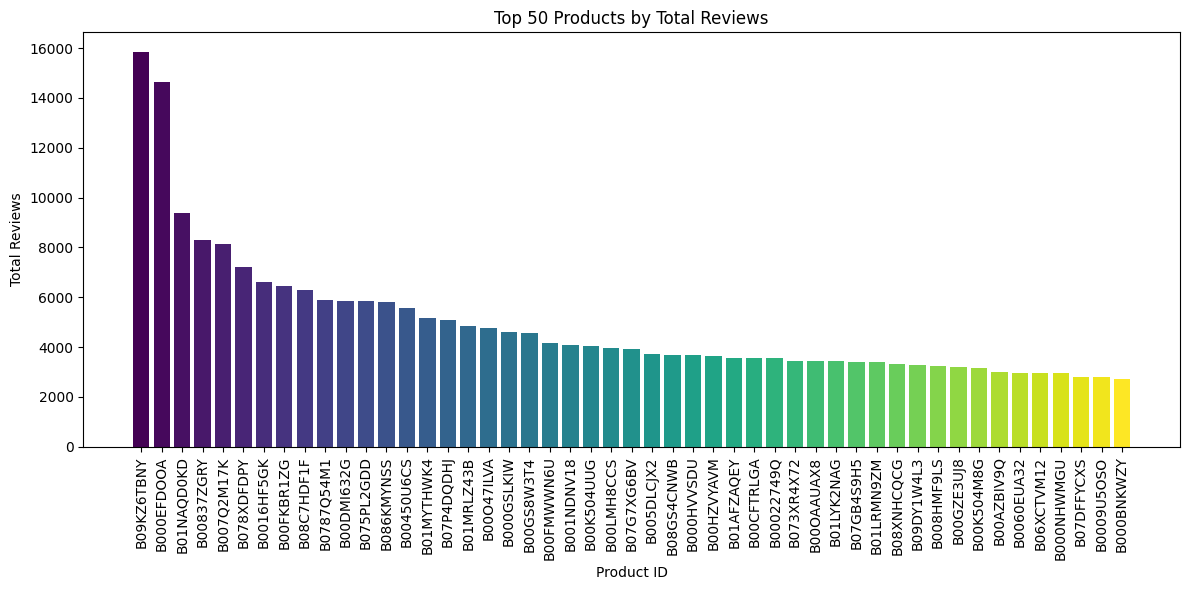

In [ ]:
from review_count import visualize_reviews
import matplotlib.pyplot as plt
import numpy as np  # Added for color generation

def visualize_reviews_inline(json_file):
    import json
    import logging

    products = []
    counts = []

    with open(json_file, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) != 2:
                logging.warning(f"Skipping malformed line: {line[:50]}...")
                continue
            try:
                json_str = json.loads(parts[1])
                data = json.loads(json_str)
                if 'product_id' in data and 'total_reviews' in data:
                    products.append(data['product_id'])
                    counts.append(data['total_reviews'])
            except Exception as e:
                logging.warning(f"Error parsing line: {line[:50]}... Error: {e}")

    if not products:
        print("No data to visualize.")
        return

    sorted_data = sorted(zip(products, counts), key=lambda x: x[1], reverse=True)
    top_products, top_counts = zip(*sorted_data[:49])

    plt.figure(figsize=(12, 6))
    # Generate different colors using a colormap
    colors = plt.cm.viridis(np.linspace(0, 1, len(top_products)))
    plt.bar(top_products, top_counts, color=colors)
    plt.xticks(rotation=90)
    plt.title('Top 50 Products by Total Reviews')  # Generalized title
    plt.xlabel('Product ID')
    plt.ylabel('Total Reviews')
    plt.tight_layout()
    plt.show()

# Display the plot
visualize_reviews_inline('/content/output.json')

**b) Reduce by counting the total number of reviews for each product.**

mapper:

- Reads each line of the .jsonl file.
- Parses it as JSON.
- Emits (asin, 1) — counting one review per product.

combiner:
- Locally sums review counts per asin before sending to the reducer (optimization).

reducer:
- Receives all counts for a given asin and outputs (asin, total_count).

In [ ]:
from mrjob.job import MRJob
from mrjob.step import MRStep
import json

class ReviewCountSeparateReduce(MRJob):

    def steps(self):
        return [
            MRStep(mapper=self.mapper,
                   combiner=self.combiner,
                   reducer=self.reducer_count_reviews),
            MRStep(reducer=self.reducer_sort_and_format)
        ]

    def mapper(self, _, line):
        try:
            review = json.loads(line)
            asin = review.get('asin', 'UNKNOWN')
            yield asin, 1
        except json.JSONDecodeError:
            pass

    def combiner(self, product_id, counts):
        yield product_id, sum(counts)

    def reducer_count_reviews(self, product_id, counts):
        yield None, (product_id, sum(counts))  # Send everything to 1 reducer

    def reducer_sort_and_format(self, _, product_count_pairs):
        # Sort by count descending
        sorted_products = sorted(product_count_pairs, key=lambda x: x[1], reverse=True)
        for product_id, count in sorted_products:
            yield None, f"Product ID: {product_id} — Total Reviews: {count}"

if __name__ == '__main__':
    ReviewCountSeparateReduce.run()


In [ ]:
!python "/content/drive/MyDrive/MCSC1/Semester 2/DataMining/SemesterProject/scripts/review_count_separate.py" < "/content/drive/MyDrive/MCSC1/Semester 2/DataMining/SemesterProject/dataset/Industrial_and_Scientific.jsonl" --output-dir "/content/drive/MyDrive/MCSC1/Semester 2/DataMining/SemesterProject/outputs/"

No configs found; falling back on auto-configuration
No configs specified for inline runner
Running step 1 of 2...
Creating temp directory /tmp/review_count_separate.root.20250404.165741.403317
reading from STDIN
Running step 2 of 2...
job output is in /content/drive/MyDrive/MCSC1/Semester 2/DataMining/SemesterProject/outputs/
Removing temp directory /tmp/review_count_separate.root.20250404.165741.403317...


# 3. Compute the Average Star Rating for Each Product



(a) Write a MapReduce job to calculate the average star rating per product.

(b) Demonstrate your ability to aggregate numerical data across the dataset.

mapper

- Takes each line of input
- Converts the string into a Python dictionary safely

Combiner
- Groups data by product ID
- Sums up all ratings and counts locally for the same product.

Reducer

- collects all (rating sum, count) tuples for each product from all the combiners.
- Aggregates the total rating and count.
- Computes average rating
- Produces a formatted string for output



In [7]:
%%writefile /content/review_avg_rating.py
import json
import logging
from mrjob.job import MRJob
import matplotlib.pyplot as plt
import numpy as np

class ReviewAverageRating(MRJob):

    def configure_args(self):
        super(ReviewAverageRating, self).configure_args()
        self.add_passthru_arg('--min-reviews', type=int, default=10, help='Minimum number of reviews to include product in average rating chart')

    def mapper(self, _, line):
        try:
            review = json.loads(line)
            asin = review.get('asin')
            # Use 'rating' field as specified by the user
            rating = review.get('rating')

            if asin: # Check if ASIN exists first
                if isinstance(rating, (int, float)):
                    # Optional: Add a check for valid rating range (e.g., 1 to 5)
                    # Based on the data schema, you might assume ratings are always 1-5 if present
                    # If you want to be strictly safe, you can add the check:
                    # if 1 <= rating <= 5:
                    yield asin, (rating, 1)
                    # else:
                    #     logging.warning(f"Skipping review with invalid rating range for ASIN {asin}: {rating}")
                else:
                    # Log specific reasons if ASIN is present but rating is not valid
                    if rating is None:
                         logging.warning(f"Skipping record for ASIN {asin} due to missing 'rating' field: {line[:50]}...")
                    else: # rating exists but is not int/float
                         logging.warning(f"Skipping record for ASIN {asin} due to non-numeric 'rating': {rating} - {line[:50]}...")
            else:
                 logging.warning(f"Skipping record due to missing ASIN: {line[:50]}...")

        except json.JSONDecodeError as e:
            logging.error(f"Malformed JSON: {line[:50]}... Error: {e}")
        except Exception as e:
             logging.error(f"Unexpected error processing line: {line[:50]}... Error: {e}")


    def combiner(self, asin, values):
        total_rating = 0
        count = 0
        for rating, c in values:
            total_rating += rating
            count += c
        yield asin, (total_rating, count)

    def reducer(self, asin, values):
        total_rating = 0
        count = 0
        for rating, c in values:
            total_rating += rating
            count += c
        if count > 0:
            avg_rating = total_rating / count
            yield None, json.dumps({"product_id": asin, "average_rating": avg_rating, "review_count": count})

# Visualization Function
def visualize_average_ratings(json_file, output_image, min_reviews=10):
    products = []
    ratings = []
    review_counts = []

    logging.info(f"Reading data from {json_file} for visualization.")

    with open(json_file, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i % 10000 == 0:
                logging.info(f"Processed {i} lines...")
            try:
                parts = line.strip().split('\t', 1)
                if len(parts) != 2:
                    logging.warning(f"Skipping malformed line (incorrect parts): {line[:50]}...")
                    continue

                json_value_str = json.loads(parts[1])
                record = json.loads(json_value_str)

                if 'product_id' in record and 'average_rating' in record and 'review_count' in record:
                     if record['review_count'] >= min_reviews:
                        products.append(record['product_id'])
                        ratings.append(record['average_rating'])
                        review_counts.append(record['review_count'])
                else:
                    logging.warning(f"Skipping line due to missing keys in parsed data: {record}")

            except json.JSONDecodeError as e:
                logging.warning(f"Skipping line due to JSON decode error on inner string: {line[:50]}... Error: {e}")
            except Exception as e:
                logging.warning(f"Skipping line due to general parse error: {line[:50]}... Error: {e}")

    logging.info(f"Finished reading data. Found {len(products)} products meeting criteria.")

    if not products:
        logging.error("No valid product ratings meeting the minimum review count to visualize.")
        plt.figure()
        plt.text(0.5, 0.5, 'No data to visualize', horizontalalignment='center', verticalalignment='center')
        plt.savefig(output_image)
        plt.close()
        print(f"Generated empty plot image to {output_image}")
        return

    # Sort by average rating (descending) - Use combined list for sorting
    sorted_data = sorted(zip(products, ratings, review_counts), key=lambda x: x[1], reverse=True)

    # Select top 50 after sorting
    top_products, top_ratings, top_review_counts = zip(*sorted_data[:40])

    # Normalize bar indices for color mapping (optional, but keep if desired)
    colors = plt.cm.viridis(np.linspace(0, 1, len(top_products)))

    # Create a figure and an Axes object
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the bar chart on the Axes object
    ax.bar(top_products, top_ratings, color=colors)

    ax.set_ylim(0, 5.1) # Set y-axis limit for star ratings
    ax.set_xticklabels(top_products, rotation=90) # Use set_xticklabels on the axes
    ax.set_title(f"Top {min(50, len(top_products))} Products by Average Star Rating (Min {min_reviews} Reviews)") # Dynamic title
    ax.set_xlabel("Product ID")
    ax.set_ylabel("Average Rating")

    fig.tight_layout() # Adjust layout using the figure

    # Save the figure. Ensure no colorbar is added here.
    fig.savefig(output_image)
    plt.close(fig) # Close the figure specifically

    print(f"Saved plot to {output_image}")


if __name__ == '__main__':
    logging.basicConfig(level=logging.INFO)
    ReviewAverageRating.run()

Overwriting /content/review_avg_rating.py


In [8]:
!python3 /content/review_avg_rating.py "/content/drive/MyDrive/MCSC1/Semester 2/DataMining/SemesterProject/dataset/Industrial_and_Scientific.jsonl" > /content/avg_ratings.json

No configs found; falling back on auto-configuration
INFO:mrjob.conf:No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/review_avg_rating.root.20250529.125308.043108
INFO:mrjob.runner:Creating temp directory /tmp/review_avg_rating.root.20250529.125308.043108
Running step 1 of 1...
INFO:mrjob.sim:Running step 1 of 1...
job output is in /tmp/review_avg_rating.root.20250529.125308.043108/output
INFO:mrjob.runner:job output is in /tmp/review_avg_rating.root.20250529.125308.043108/output
Streaming final output from /tmp/review_avg_rating.root.20250529.125308.043108/output...
INFO:mrjob.runner:Streaming final output from /tmp/review_avg_rating.root.20250529.125308.043108/output...
Removing temp directory /tmp/review_avg_rating.root.20250529.125308.043108...
INFO:mrjob.runner:Removing temp directory /tmp/review_avg_rating.root.20250529.125308.043108...


Attempting to visualize data from /content/avg_ratings.json


/content/review_avg_rating.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_products, rotation=90) # Use set_xticklabels on the axes


Saved plot to /content/avg_rating_plot.png


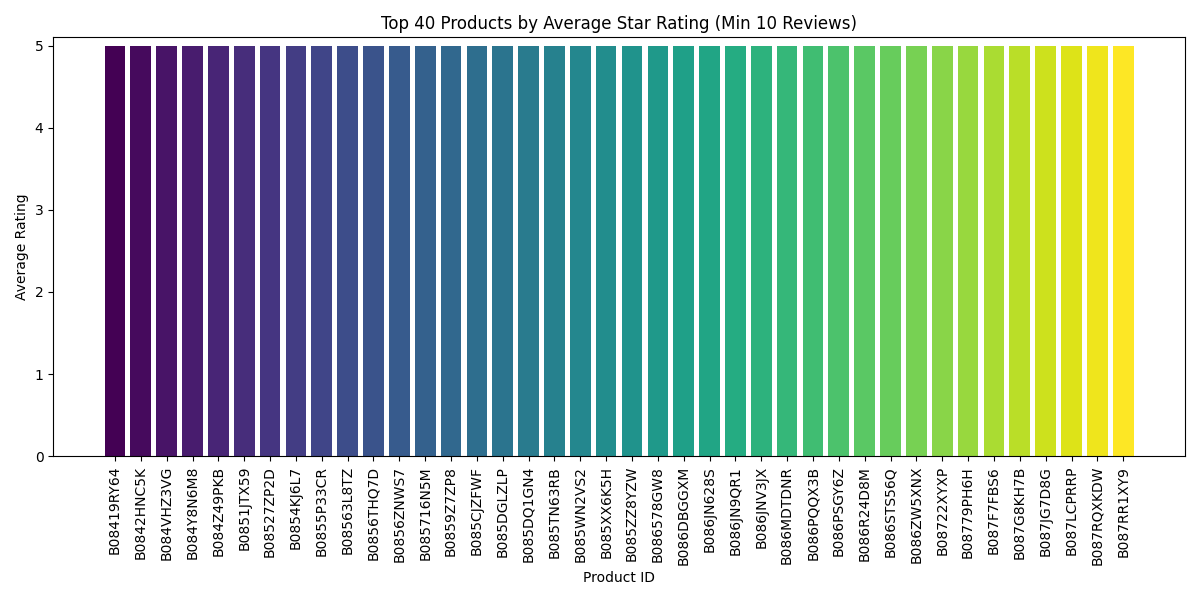

In [9]:
from review_avg_rating import visualize_average_ratings
import json
import logging
import matplotlib.pyplot as plt
from IPython.display import Image, display
import numpy as np  # Ensure this is imported if used in visualize_average_ratings
import os

# Set up basic logging
logging.basicConfig(level=logging.INFO)

# Define the paths
output_file = "/content/avg_ratings.json"
plot_path = "/content/avg_rating_plot.png"

# Visualize the results
print(f"Attempting to visualize data from {output_file}")
visualize_average_ratings(output_file, plot_path, min_reviews=10)

# Display the plot inline in the notebook
if os.path.exists(plot_path):
    display(Image(filename=plot_path))
else:
    print(f"Could not find {plot_path}. Plot generation might have failed.")


# 4. Identify the Top Ten Most Reviewed Products

(a) Write a MapReduce job that counts the number of reviews per product.

(b) Sort the products by their review count and extract the top ten.

- Mapper (mapper_count): Reads input lines, parses them as JSON, extracts the product_id, and yields a key-value pair with product_id and a count of 1 (indicating one review for that product).

- Reducer (reducer_count): Aggregates the counts for each product_id, summing the review counts for each product.

- Top-N Reducer (reducer_top_n): After aggregating the counts, it extracts the top N products by review count using the heapq.nlargest function. It then writes the results to a CSV file specified by the --output argument.



In [ ]:
%%writefile /content/review_count.py
import json
import re
import logging
from mrjob.job import MRJob
import matplotlib.pyplot as plt
import numpy as np

class ReviewCount(MRJob):

    def configure_args(self):
        super(ReviewCount, self).configure_args()
        self.add_passthru_arg('--top-n', type=int, default=10, help='Number of top products to output')

    def mapper(self, _, line):
        try:
            review = json.loads(line)
            asin = review.get('asin')
            if asin:
                yield asin, 1
            else:
                logging.warning(f"Missing ASIN in record: {line[:50]}...")
        except json.JSONDecodeError as e:
            logging.error(f"Malformed JSON: {line[:50]}... Error: {e}")

    def combiner(self, product_id, counts):
        yield product_id, sum(counts)

    def reducer_init(self):
        self.review_counts = []

    def reducer(self, product_id, counts):
        total = sum(counts)
        self.review_counts.append((product_id, total))

    def reducer_final(self):
        import heapq
        top_n = self.options.top_n
        heap = []
        for product_id, total in self.review_counts:
            if len(heap) < top_n:
                heapq.heappush(heap, (total, product_id))
            else:
                heapq.heappushpop(heap, (total, product_id))
        for total, product_id in sorted(heap, reverse=True):
            yield None, json.dumps({"product_id": product_id, "total_reviews": total})

logging.basicConfig(level=logging.WARNING)

def visualize_reviews(json_file, output_image):
    products = []
    counts = []

    with open(json_file, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) != 2:
                logging.warning(f"Skipping malformed line: {line[:50]}...")
                continue

            try:
                # First parse outer string: gives you a JSON string
                json_str = json.loads(parts[1])

                # Now parse the JSON string into a dictionary
                data = json.loads(json_str)

                # Check if data is a dictionary
                if not isinstance(data, dict):
                    logging.warning(f"Skipping line where JSON did not parse to a dict: {line[:50]}...")
                    continue

                # Ensure expected keys are present
                if 'product_id' in data and 'total_reviews' in data:
                    products.append(data['product_id'])
                    counts.append(data['total_reviews'])
                else:
                    logging.warning(f"Missing keys in parsed data: {data}")
            except Exception as e:
                logging.warning(f"Error parsing line: {line[:50]}... Error: {e}")

    if not products:
        logging.error("No data to visualize after processing file.")
        return

    # Sort by number of reviews (descending)
    sorted_data = sorted(zip(products, counts), key=lambda x: x[1], reverse=True)

    # Use top 20 for visualization
    top_products, top_counts = zip(*sorted_data[:20])

    plt.figure(figsize=(12, 6))
    plt.bar(top_products, top_counts, color='skyblue')
    plt.xticks(rotation=90)
    plt.title('Top 10 Products by Total Reviews')
    plt.xlabel('Product ID')
    plt.ylabel('Total Reviews')
    plt.tight_layout()
    plt.savefig(output_image)
    plt.close()
    print(f"Chart saved to {output_image}")
if __name__ == '__main__':
    logging.basicConfig(level=logging.INFO)
    ReviewCount.run()

Writing /content/review_count.py


In [ ]:
!python /content/review_count.py --top-n 10 "/content/drive/MyDrive/MCSC1/Semester 2/DataMining/SemesterProject/dataset/Industrial_and_Scientific.jsonl" > /content/output.json

No configs found; falling back on auto-configuration
INFO:mrjob.conf:No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/review_count.root.20250521.184226.484040
INFO:mrjob.runner:Creating temp directory /tmp/review_count.root.20250521.184226.484040
Running step 1 of 1...
INFO:mrjob.sim:Running step 1 of 1...
job output is in /tmp/review_count.root.20250521.184226.484040/output
INFO:mrjob.runner:job output is in /tmp/review_count.root.20250521.184226.484040/output
Streaming final output from /tmp/review_count.root.20250521.184226.484040/output...
INFO:mrjob.runner:Streaming final output from /tmp/review_count.root.20250521.184226.484040/output...
Removing temp directory /tmp/review_count.root.20250521.184226.484040...
INFO:mrjob.runner:Removing temp directory /tmp/review_count.root.20250521.184226.484040...


<ipython-input-8-0d6dd32b6160>:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10')  # You can also try 'tab20' or 'Set3'


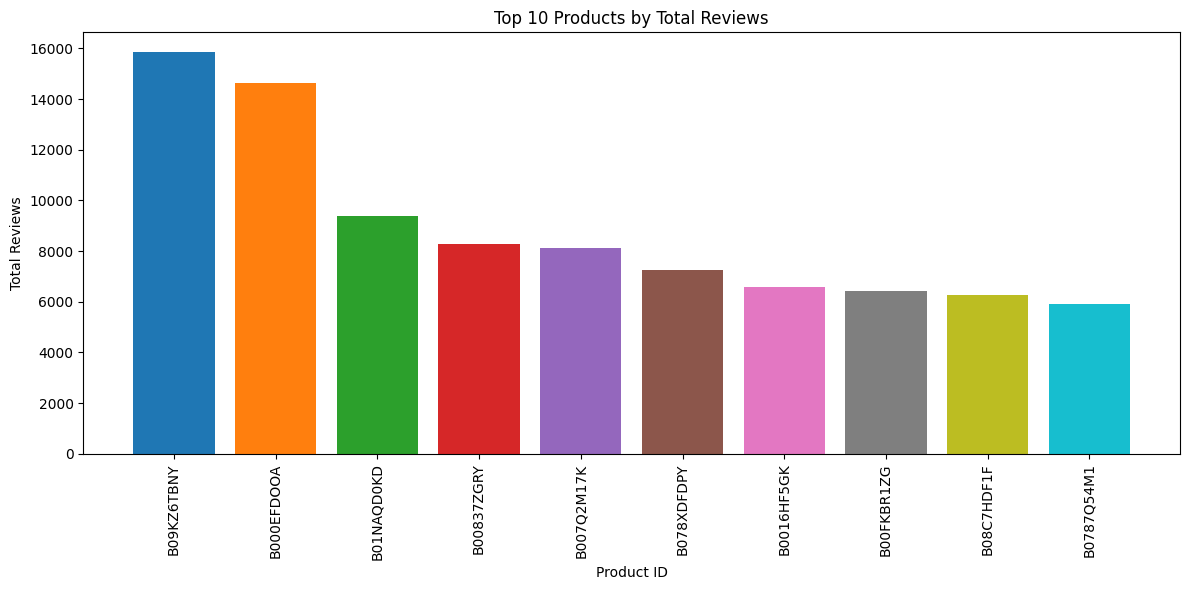

In [ ]:
from review_count import visualize_reviews
import matplotlib.pyplot as plt

def visualize_reviews_inline(json_file):
    import json
    import logging
    import matplotlib.cm as cm
    import numpy as np

    products = []
    counts = []

    with open(json_file, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) != 2:
                logging.warning(f"Skipping malformed line: {line[:50]}...")
                continue
            try:
                json_str = json.loads(parts[1])
                data = json.loads(json_str)
                if 'product_id' in data and 'total_reviews' in data:
                    products.append(data['product_id'])
                    counts.append(data['total_reviews'])
            except Exception as e:
                logging.warning(f"Error parsing line: {line[:50]}... Error: {e}")

    if not products:
        print("No data to visualize.")
        return

    sorted_data = sorted(zip(products, counts), key=lambda x: x[1], reverse=True)
    top_products, top_counts = zip(*sorted_data[:10])

    # Generate distinct colors using a colormap
    cmap = cm.get_cmap('tab10')  # You can also try 'tab20' or 'Set3'
    colors = [cmap(i % 10) for i in range(len(top_products))]

    plt.figure(figsize=(12, 6))
    plt.bar(top_products, top_counts, color=colors)
    plt.xticks(rotation=90)
    plt.title('Top 10 Products by Total Reviews')
    plt.xlabel('Product ID')
    plt.ylabel('Total Reviews')
    plt.tight_layout()
    plt.show()

# Display the plot
visualize_reviews_inline('/content/output.json')


# 5. Calculate the Average Helpfulness Score for Reviews

The helpfulness score is defined as:

Helpfulness Score = Number of Helpful VotesTotal Votes (Helpful + Unhelpful).
*   Write a MapReduce job to compute the average helpfulness score of all reviews.



In [ ]:
from mrjob.job import MRJob
from mrjob.step import MRStep
import ast

class AverageHelpfulnessScore(MRJob):

    def steps(self):
        return [
            MRStep(
                mapper=self.mapper_extract_helpfulness_score,
                reducer=self.reducer_compute_average_helpfulness
            )
        ]

    def mapper_extract_helpfulness_score(self, _, line):
        try:
            review = ast.literal_eval(line)  # Parse the Python dict string
            helpful = review.get('helpful_vote', 0)
            unhelpful = 1  # Assumption: 1 unhelpful vote per review if not given
            total_votes = helpful + unhelpful

            if total_votes > 0:
                score = helpful / total_votes
                yield "average_helpfulness_score", (score, 1)
        except Exception as e:
            self.log.warning(f"Skipping line due to error: {e}")

    def reducer_compute_average_helpfulness(self, key, values):
        total_score = 0
        count = 0
        for score, c in values:
            total_score += score
            count += c
        if count > 0:
            yield key, round(total_score / count, 4)

!python avg_helpfulness_score.py "/content/drive/MyDrive/MCSC1/Semester 2/DataMining/SemesterProject/dataset/Industrial_and_Scientific.jsonl"

Writing /content/avg_helpfulness_score.py


In [ ]:
!python avg_helpfulness_score.py "/content/drive/MyDrive/MCSC1/Semester 2/DataMining/SemesterProject/dataset/Industrial_and_Scientific.jsonl"

In [ ]:
%%writefile /content/avg_helpfulness_score.py
import json
import sys
from mrjob.job import MRJob
from mrjob.step import MRStep

class AverageHelpfulnessScore(MRJob):

    def steps(self):
        return [
            MRStep(
                mapper_init=self.mapper_init,
                mapper=self.mapper_extract_helpfulness_score,
                reducer=self.reducer_compute_average_helpfulness
            )
        ]

    def mapper_init(self):
        self.line_count = 0
        self.valid_review_count = 0
        self.non_zero_vote_count = 0

    def mapper_extract_helpfulness_score(self, _, line):
        self.line_count += 1
        self.increment_counter('mapper', 'total_lines', 1)
        try:
            # Decode the input line if it's in bytes
            if isinstance(line, bytes):
                line = line.decode('utf-8')

            line_str = line.strip()
            review = json.loads(line_str)
            self.valid_review_count += 1
            self.increment_counter('mapper', 'valid_reviews', 1)

            helpful = review.get('helpful_vote', 0)
            unhelpful = review.get('unhelpful_vote', 0)
            total_votes = helpful + unhelpful

            # Debug output to stderr (encoded to bytes)
            if self.line_count <= 5:
                msg = f"Line {self.line_count}: helpful={helpful}, unhelpful={unhelpful}, total_votes={total_votes}\n"
                sys.stderr.write(msg.encode())

            if total_votes > 0:
                self.non_zero_vote_count += 1
                self.increment_counter('mapper', 'non_zero_vote_reviews', 1)
                score = helpful / total_votes
                yield "average_helpfulness_score", (score, 1)

        except Exception as e:
            self.increment_counter('mapper', 'skipped_lines', 1)
            msg = f"Skipping line {self.line_count} due to error: {e}\n"
            sys.stderr.write(msg.encode())

    def reducer_compute_average_helpfulness(self, key, values):
        total_score = 0
        count = 0
        for score, c in values:
            total_score += score
            count += c
        if count > 0:
            yield key, round(total_score / count, 4)
        else:
            yield key, "No reviews with non-zero votes found"

if __name__ == '__main__':
    AverageHelpfulnessScore.run()


Writing /content/avg_helpfulness_score.py


In [ ]:
!python /content/avg_helpfulness_score.py "/content/drive/MyDrive/MCSC1/Semester 2/DataMining/SemesterProject/dataset/Industrial_and_Scientific.jsonl" > /content/avg_helpful_output.json


No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/avg_helpfulness_score.root.20250525.145805.376354
Running step 1 of 1...

Counters: 3
	mapper
		non_zero_vote_reviews=1191029
		total_lines=5183005
		valid_reviews=5183005

job output is in /tmp/avg_helpfulness_score.root.20250525.145805.376354/output
Streaming final output from /tmp/avg_helpfulness_score.root.20250525.145805.376354/output...
Removing temp directory /tmp/avg_helpfulness_score.root.20250525.145805.376354...


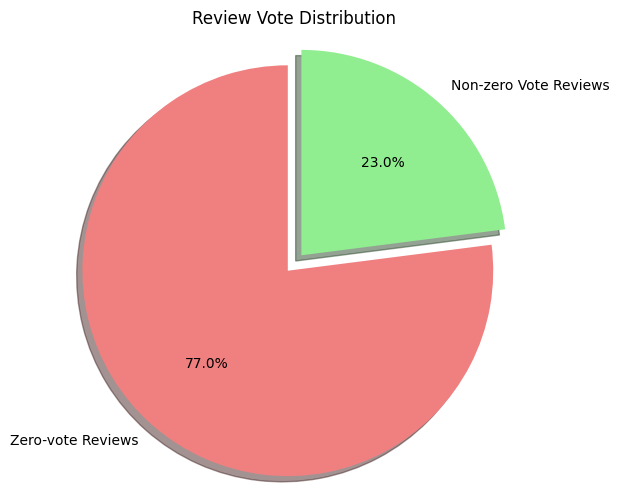

In [ ]:
import matplotlib.pyplot as plt

# Values from your output
non_zero_vote_reviews = 1191029
zero_vote_reviews = 5183005 - non_zero_vote_reviews

# Labels and data
labels = ['Zero-vote Reviews', 'Non-zero Vote Reviews']
sizes = [zero_vote_reviews, non_zero_vote_reviews]
colors = ['lightcoral', 'lightgreen']
explode = (0.05, 0.05)  # Slightly "explode" both slices

# Plot
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
        startangle=90, explode=explode, shadow=True)
plt.title('Review Vote Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()
